In [1]:
#import lazypredict
import mat4py
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import scipy.io
import os 
#from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import KFold
import math
import scipy.io
import matplotlib.pyplot as plt
from random import sample

## 
## load data


CellNames = scipy.io.loadmat('../Cells2Connectomes/CellType_Names.mat')
CellNames = CellNames['cellnames']


Connectomes = scipy.io.loadmat('../Cells2Connectomes/Connectomes.mat')
Connectome_direct = Connectomes['C_dir']


'''

Region volumes, in a 424 vector, to get connectivity density, divide
% each row in connectomes by each entry in the vector to get density. Units
% are in 200 micron per vertex voxels.

'''

CellType_volumn = mat4py.loadmat('../Cells2Connectomes/Regional_Volumes.mat')
CellType_volumn = CellType_volumn['region_vols']
Celltype_volumn =np.array([np.array(xi) for xi in CellType_volumn])
print(Celltype_volumn.shape)

# Nomarlize by the entry

Connectome_direct_density = Connectome_direct/Celltype_volumn

# This is the new version that I got from Justin

Cell_type = mat4py.loadmat('../Cells2Connectomes/Tasic_nG_606_TypeDensity.mat')
Cell_type = Cell_type['cell_type_density_nG606']
Celltype_mtx =np.array([np.array(xi) for xi in Cell_type])


Celltype_mtx_norm = (Celltype_mtx.max(axis=0)-Celltype_mtx) / (Celltype_mtx.max(axis=0) - Celltype_mtx.min(axis=0) )

# A function which can convert a 2d list to a 1d list, I am doing this because the wrong orentation of the Region names

def flatten_list(_2d_list):
    flat_list = []
    for element in _2d_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

Region_maps = mat4py.loadmat('../Cells2Connectomes/Region_Names.mat')
Region_maps = Region_maps['region_names']
Region_maps = mat4py.loadmat('../Cells2Connectomes/Region_Names.mat')
Region_maps = Region_maps['region_names']

Regionmaps_df = pd.DataFrame(Region_maps,columns = ['Anno1','Anno2','Anno3'])

Region_maps_list = flatten_list(Region_maps)
Region_maps_list

Region_maps_array = np.array(Region_maps_list)
Region_maps_array_2d = np.reshape(Region_maps_array, (3,212))
Regionmaps_df['Anno1'] = Region_maps_array_2d[0]
Regionmaps_df['Anno2'] = Region_maps_array_2d[1]
Regionmaps_df['Anno3'] = Region_maps_array_2d[2]


index_l =Regionmaps_df.index
index_r = [x+ 212 for x in index_l]
index = list(index_l) + list(index_r)

# load distance

Distance = mat4py.loadmat('../Cells2Connectomes/Interregional_Distances.mat')
Distance = Distance['D']
Distance_mtx =np.array([np.array(xi) for xi in Distance])


# previous I do this by onehotpot but now I do it by number
Regionmaps_df_whole = Regionmaps_df.append(Regionmaps_df)
Regionmaps_df_whole.head()

#encode the features, 
# previous I do this by onehotpot but now I do it by number
Regionmaps_df_whole = Regionmaps_df.append(Regionmaps_df)

Regionmaps_df_whole['Anno2'] = pd.Categorical(Regionmaps_df_whole['Anno2'] )
Regionmaps_df_whole['code'] = Regionmaps_df_whole['Anno2'].cat.codes
Region_encodes = np.array(Regionmaps_df_whole['code'])

(424, 1)


In [4]:
ZeiselData = mat4py.loadmat('../Cells2Connectomes/MISS_CellTypes_ZeiselData_Neuromods.mat')
Cell_labels = ZeiselData['classkey']
ZeiselData = ZeiselData['Bvals_Zeisel']
ZeiselData_mtx = np.array([np.array(xi) for xi in ZeiselData])
ZeiselData_mtx_norm = (ZeiselData_mtx -ZeiselData_mtx.min(axis=0)) / (ZeiselData_mtx.max(axis=0) - ZeiselData_mtx.min(axis=0) )

ZeiselData = mat4py.loadmat('../Cells2Connectomes/MISS_CellTypes_ZeiselData_Neuromods.mat')
ZeiselData.keys()

dict_keys(['Bvals_Zeisel', 'Bvals_Zeisel_chol', 'Bvals_Zeisel_dop', 'Bvals_Zeisel_neuromod', 'Bvals_Zeisel_nor', 'Bvals_Zeisel_pep', 'Bvals_Zeisel_ser', 'classkey', 'classkey_chol', 'classkey_dop', 'classkey_neuromod', 'classkey_nor', 'classkey_pep', 'classkey_ser'])

In [3]:
# random forest

# build a df to store the information

# instead use the subset, this time I am trying the whole, which might be not suitable for ML, but I just wanted a positive control
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []


for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        
        if i >= 212 :
            i_ = i - 212
        else:
            i_ = i
        
        if j >= 212 :
            j_ = j - 212
        else:
            j_ = j
        if (Regionmaps_df['Anno2'][i_] == Regionmaps_df['Anno2'][j_] ):
            if ((i >= 212) == (j >= 212)):
                
                close_region = 1
            else: 
                close_region = 1
        else:
            close_region = 0
        

        if i == j:
            pass       
        else:

            Dataset.append(np.concatenate((ZeiselData_mtx_norm[i,:],ZeiselData_mtx_norm[j,:])))
            Target.append(Connectome_direct_density[i,j])
            
            
print('?')
Dataset = np.stack(Dataset)
capped_Target = [math.log2(x+1) for x in Target]
Target =np.array([np.array(xi) for xi in capped_Target])   

Dataset= Dataset[list(np.where(Target != 0)[0])]
Target = Target[list(np.where(Target != 0)[0])]
print(Dataset.shape)
print(Target.shape) 

?
(64376, 400)
(64376,)


In [ ]:
# For the short distance

   
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  

# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []

p = 0 
for train_index, test_index in kf.split(df_sD):
    p = p + 1
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = df_sD.iloc[sub1], df_sD.iloc[sub2]
    y_train, y_test = Target_sD[sub1], Target_sD[sub2]
    RF_model_1 = RandomForestRegressor(n_estimators=100,max_features = 20,max_depth=30)
    RF_model_1.fit(X_train, y_train)
    print('Traing fit')
    Predict = RF_model_1.predict(X_train)
    print(r2_score(y_train, Predict))
    print('Testing fit')
    Predict = RF_model_1.predict(X_test)
    print(r2_score(y_test, Predict))
    list_r2.append(r2_score(y_test, Predict))
    importances = RF_model_1.feature_importances_
    indices = np.argsort(importances)[::-1]
    Celltype_scores = importances[:200] + importances[200:]
    if p ==1 :
        
        df_feature_important_s = {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        print(Celltype_scores.shape)
        df_feature_important_s = pd.DataFrame(data=df_feature_important_s,dtype=np.int32)
    else:
        _df_feature_important_s = {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        _df_feature_important_s = pd.DataFrame(data=_df_feature_important_s,dtype=np.int32)
        df_feature_important_s = df_feature_important_s.append(_df_feature_important_s)
        
s_cell = list_r2.copy()

In [8]:
from scipy import  stats  
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  
p = 0
# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []
list_pearson = []
for train_index, test_index in kf.split(Dataset):
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = Dataset[sub1], Dataset[sub2]
    y_train, y_test = Target[sub1], Target[sub2]
  

    #reg = LazyRegressor(verbose=1, predictions=True,ignore_warnings=False, custom_metric=None)
    #models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    #print(models)
    
    #RF_model = RandomForestRegressor(n_estimators=100,max_features = 60,max_depth=20,min_samples_split =3)#,warm_start = True)  # height
    
    RF_model = RandomForestRegressor(n_estimators=100, max_features=20)
    RF_model.fit(X_train, y_train)
    print('Traing fit')
    Predict = RF_model.predict(X_train)
    print(r2_score(y_train, Predict))
    print('Testing fit')
    Predict = RF_model.predict(X_test)
    
    importances = RF_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    Celltype_scores = importances[:200] + importances[200:]
    p = p + 1
    if p ==1 :
        
        df_feature_important_all = {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        #print(Celltype_scores.shape)
        df_feature_important_all = pd.DataFrame(data=df_feature_important_all,dtype=np.int32)
    else:
        _df_feature_important_all = {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        _df_feature_important_all = pd.DataFrame(data=_df_feature_important_all,dtype=np.int32)
        df_feature_important_all = df_feature_important_all.append(_df_feature_important_all)
        
    print(r2_score(y_test, Predict))
    print('stats.pearsonr')
    print(stats.pearsonr(y_test, Predict)[0])
    list_r2.append(r2_score(y_test, Predict))
    list_pearson.append(stats.pearsonr(y_test, Predict)[0])
    


Traing fit
0.9442179523057702
Testing fit
0.5955576407223035
stats.pearsonr
0.7785427900588633
Traing fit
0.9440771162034498
Testing fit
0.6027710320187605
stats.pearsonr
0.7842825533202766
Traing fit
0.9436169261124832
Testing fit
0.6031705786102647
stats.pearsonr
0.7850499731904433
Traing fit
0.9442011589151974
Testing fit
0.5995579541019694
stats.pearsonr
0.7808465573241188
Traing fit
0.9442580204513813
Testing fit
0.5963698165298235
stats.pearsonr
0.7787859533935468
Traing fit
0.943630460626659
Testing fit
0.619882607230951
stats.pearsonr
0.7928584803912878
Traing fit
0.9441861739388911
Testing fit
0.6260662945768758
stats.pearsonr
0.7984285896573562
Traing fit
0.9440533446229759
Testing fit
0.596194610125679
stats.pearsonr
0.7789687429199827
Traing fit
0.9442781019677409
Testing fit
0.5758546293264628
stats.pearsonr
0.7635583729688225
Traing fit
0.9436593559879185
Testing fit
0.6114857345608604
stats.pearsonr
0.7876161114215336


In [10]:
df_feature_important_all.to_csv('./Zeisel.csv', sep = '\t')

In [ ]:
Zeisel

In [ ]:
# corrlation

In [9]:
import seaborn as sns

similarity_200 = np.zeros((424,424))
similarity_200_ls = []
conn_ls = []
for i in range(424):
    for j in range(424):
        similarity_200[i,j] = stats.pearsonr(ZeiselData_mtx_norm[i,:],ZeiselData_mtx_norm[j,:])[0]
        similarity_200_ls.append(similarity_200[i,j])


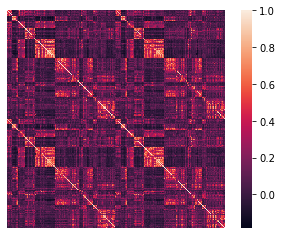

In [12]:
sns_plot = sns.heatmap(similarity_200,
            xticklabels=False, yticklabels=False,
            square= True)

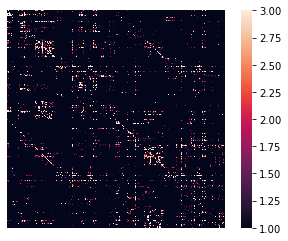

In [15]:
Connectome_direct_density_log2 = np.log2(Connectome_direct_density +1)

sns_plot = sns.heatmap(Connectome_direct_density_log2,
            xticklabels=False, yticklabels=False,
            square= True,vmin=1, vmax = 3)
fig = sns_plot.get_figure()

In [19]:
canvas = np.zeros((424,424))
for i in range(424):
    for j in range(424):
        canvas[i,j] = RF_model.predict(np.concatenate((ZeiselData_mtx_norm[i,:],
                                                  ZeiselData_mtx_norm[j,:])).reshape(1,400))

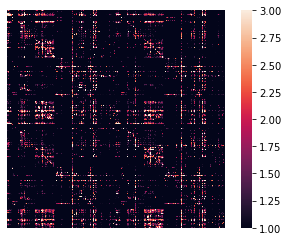

In [21]:
sns_plot = sns.heatmap(canvas,
            xticklabels=False, yticklabels=False,
            square= True,vmin=1, vmax = 3)
fig = sns_plot.get_figure()

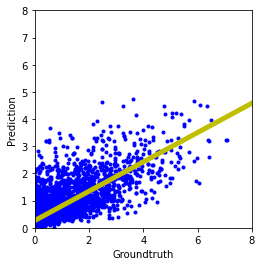

In [13]:
fig, ax = plt.subplots()
plt.xlabel('Groundtruth')
plt.ylabel('Prediction')
random_index = range(len(y_test))
#polynomial fit with degree = 2
model = np.poly1d(np.polyfit(y_test, Predict, 1))

polyline = np.linspace(0, 8, 50)
ax.plot(y_test, Predict, 'b.')
plt.plot(polyline, model(polyline), 'y',linewidth=5)
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))


In [25]:
# classification 
# random forest

# build a df to store the information

# instead use the subset, this time I am trying the whole, which might be not suitable for ML, but I just wanted a positive control
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []


for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        # ignore self connectivity

        if i == j:
            pass       
        else:

            #_Dataset_Training = np.concatenate((Dataset_Train_set[i,:],Dataset_Train_set[j,:]))
            #Dataset_Training = np.stack((Dataset_Training,_Dataset_Training))
            Dataset.append(np.concatenate((ZeiselData_mtx_norm[i,:],ZeiselData_mtx_norm[j,:])))
            Target.append(Connectome_direct_density[i,j])
            
            

class_Dataset = np.stack(Dataset)

class_Target = [1 if x >0 else x for x in Target]
class_Target =np.array([np.array(xi) for xi in class_Target])   




In [27]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier

kf = KFold(n_splits=10, shuffle= True)
auc_list = []
acc_list = []
p = 0
for train_index, test_index in kf.split(class_Dataset):
    #print(train_index)
    #print(test_index)
    p = p +1
    print(p)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train_class, X_test_class = class_Dataset[sub1], class_Dataset[sub2]
    y_train_class, y_test_class = class_Target[sub1], class_Target[sub2]
    RF_model_class = RandomForestClassifier(n_estimators=100, max_features = 20)
    RF_model_class.fit(X_train_class, y_train_class)

    #list_r2.append(r2_score(y_test, Predict))
    predicts_class = RF_model_class.predict_proba(X_test_class)
     
    auc_list.append(metrics.roc_auc_score(y_test_class, predicts_class[:,1]))
    bin_predict = [1 if x >0.5 else 0 for x in predicts_class[:,1]]


1


ValueError: Found input variables with inconsistent numbers of samples: [6437, 17936]

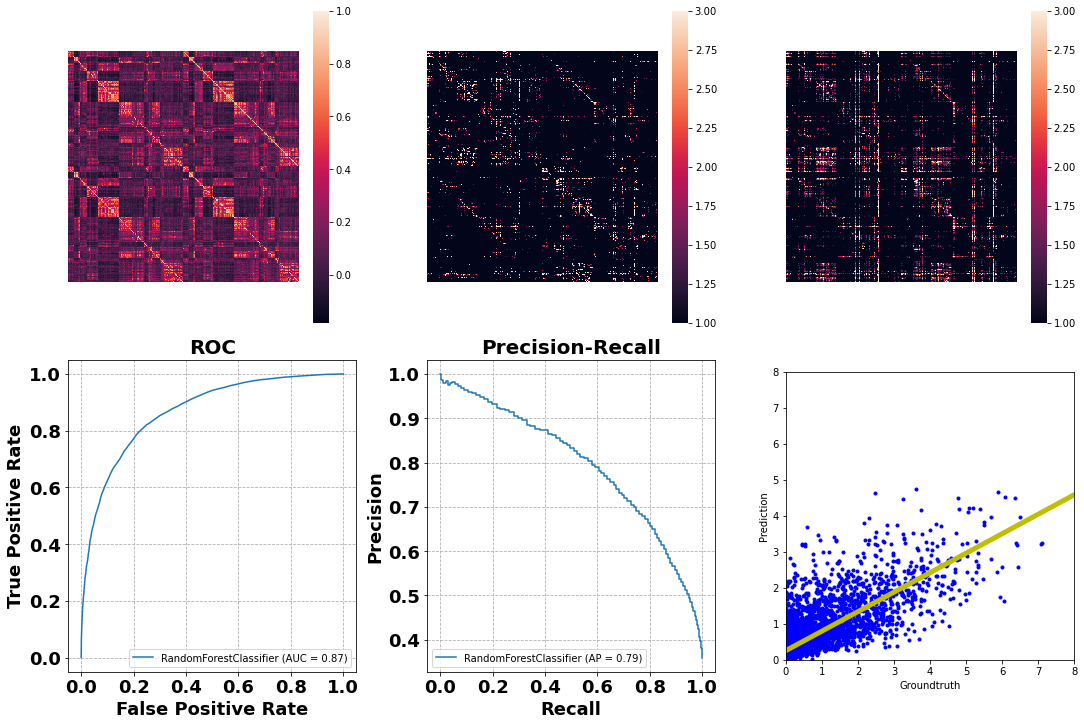

In [28]:
from matplotlib.gridspec import GridSpec
import sklearn.metrics as metrics


fig = plt.figure(figsize=(15, 10))

gs = GridSpec(nrows=2, ncols=3)
if 1 ==1:
    ax1 = fig.add_subplot(gs[0,0])
    sns_plot = sns.heatmap(similarity_200,
                xticklabels=False, yticklabels=False,
                square= True, ax = ax1)    

if 1 == 1:
    ax2 = fig.add_subplot(gs[0,1])
    sns_plot = sns.heatmap(Connectome_direct_density_log2, ax = ax2,
            xticklabels=False, yticklabels=False,
            square= True,vmin=1, vmax = 3)

if 1 == 1:
    ax3 = fig.add_subplot(gs[0,2])
    sns_plot = sns.heatmap(canvas, ax = ax3,
            xticklabels=False, yticklabels=False,
            square= True,vmin=1, vmax = 3)


if 1 == 1:
    ax4 = fig.add_subplot(gs[1,0])
    metrics.plot_roc_curve(RF_model_class, X_test_class, y_test_class,ax=ax4)
    ax4.set_title('ROC', fontsize = 20, weight = 'bold')
    ax4.grid(linestyle='--')
    plt.ylabel('True Positive Rate', weight ='bold', fontsize = 18)
    plt.xlabel('False Positive Rate', weight ='bold', fontsize = 18)  
    plt.xticks(weight ='bold', fontsize = 18)
    plt.yticks(weight ='bold', fontsize = 18)

            
if 1 == 1:
    ax5 = fig.add_subplot(gs[1,1])
    metrics.plot_precision_recall_curve(RF_model_class, X_test_class, y_test_class,ax=ax5)
    ax5.set_title('Precision-Recall', fontsize = 20, weight = 'bold')
    ax5.grid(linestyle='--')
    plt.ylabel('Precision', weight ='bold', fontsize = 18)
    plt.xlabel('Recall', weight ='bold', fontsize = 18)
    plt.xticks(weight ='bold', fontsize = 18)
    plt.yticks(weight ='bold', fontsize = 18)

if 1==1:
    ax6 = fig.add_subplot(gs[1,2])
    plt.xlabel('Groundtruth')
    plt.ylabel('Prediction')
    random_index = range(len(y_test))
    #polynomial fit with degree = 2
    model = np.poly1d(np.polyfit(y_test, Predict, 1))

    polyline = np.linspace(0, 8, 50)
    ax6.plot(y_test, Predict, 'b.')
    plt.plot(polyline, model(polyline), 'y',linewidth=5)
    ax6.set_xlim(0, 8)
    ax6.set_ylim(0, 8)
    x0,x1 = ax6.get_xlim()
    y0,y1 = ax6.get_ylim()
    ax6.set_aspect(abs(x1-x0)/abs(y1-y0))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()


#### Add distance

In [12]:
Distance = mat4py.loadmat('../Cells2Connectomes/Interregional_Distances_JLT.mat')
Distance = Distance['D']
Distance_mtx =np.array([np.array(xi) for xi in Distance])

# random forest

# build a df to store the information

# instead use the subset, this time I am trying the whole, which might be not suitable for ML, but I just wanted a positive control
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []


for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        #print(i)
        #print(j)
        if i == j:
            pass       
        else:

            #_Dataset_Training = np.concatenate((Dataset_Train_set[i,:],Dataset_Train_set[j,:]))
            #Dataset_Training = np.stack((Dataset_Training,_Dataset_Training))
            Dataset.append(np.concatenate((ZeiselData_mtx_norm[i,:],
                                           ZeiselData_mtx_norm[j,:],Distance_mtx[i,j].reshape(1))))

            Target.append(Connectome_direct_density[i,j])
            
            
print('?')
Dataset = np.stack(Dataset)
#capped_Target = [5 if x>5 else x for x in Target]
capped_Target = [math.log2(x+1) for x in Target]
Target =np.array([np.array(xi) for xi in capped_Target])   

Dataset= Dataset[list(np.where(Target != 0)[0])]
Target = Target[list(np.where(Target != 0)[0])]
print(Dataset.shape)
print(Target.shape) 

?
(64376, 401)
(64376,)


In [41]:
# convert the numpy to pandas

df = pd.DataFrame(Dataset, columns = list(range(401)))



df_sD = df[df[400]<=np.percentile(df[400], 25)]
Target_sD = Target[df[400]<=np.percentile(df[400], 25)]
df_lD = df[df[400]>np.percentile(df[400], 75)]
Target_lD = Target[df[400]>np.percentile(df[400], 75)]


df_mD = df[(df[400]>np.percentile(df[400], 25))^(df[400]<np.percentile(df[400], 75))]
Target_mD = Target[(df[50]>np.percentile(df[400], 25))^(df[50]<np.percentile(df[400], 75))]
del df_sD[400]
del df_lD[400]
del df_mD[400]

df_sD.index = list(range(df_sD.shape[0]))
df_lD.index = list(range(df_lD.shape[0]))
df_mD.index = list(range(df_mD.shape[0]))

In [29]:
# For the short distance

   
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  

# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []

p = 0 
for train_index, test_index in kf.split(df_sD):
    p = p + 1
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = df_sD.iloc[sub1], df_sD.iloc[sub2]
    y_train, y_test = Target_sD[sub1], Target_sD[sub2]
    RF_model_1 = RandomForestRegressor(n_estimators=100,max_features = 20,max_depth=30)
    RF_model_1.fit(X_train, y_train)
    print('Traing fit')
    Predict = RF_model_1.predict(X_train)
    print(r2_score(y_train, Predict))
    print('Testing fit')
    Predict = RF_model_1.predict(X_test)
    print(r2_score(y_test, Predict))
    list_r2.append(r2_score(y_test, Predict))
    importances = RF_model_1.feature_importances_
    indices = np.argsort(importances)[::-1]
    Celltype_scores = importances[:200] + importances[200:]
    if p ==1 :
        
        df_feature_important_s = {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        print(Celltype_scores.shape)
        df_feature_important_s = pd.DataFrame(data=df_feature_important_s,dtype=np.int32)
    else:
        _df_feature_important_s = {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        _df_feature_important_s = pd.DataFrame(data=_df_feature_important_s,dtype=np.int32)
        df_feature_important_s = df_feature_important_s.append(_df_feature_important_s)
        
s_cell = list_r2.copy()

Traing fit
0.9456072598459254
Testing fit
0.6025350525950348
(200,)
Traing fit
0.944716982596977
Testing fit
0.6575771788082954
Traing fit
0.9453774027323532
Testing fit
0.5989524552971548
Traing fit
0.9458207320803376
Testing fit
0.5812817210778304
Traing fit
0.9451997650071635
Testing fit
0.6123330978869264
Traing fit
0.9453311277305889
Testing fit
0.6148584979896017
Traing fit
0.9442241196314692
Testing fit
0.6375950183748342
Traing fit
0.9455730379851035
Testing fit
0.6151073696891476
Traing fit
0.9459884296964394
Testing fit
0.5847139036614588
Traing fit
0.9457786730088014
Testing fit
0.6054023500005299


In [44]:
df_mD.head(16094)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.000000,0.000000,...,0.323909,0.243480,0.002021,0.000000,0.389733,0.250445,0.157035,0.170348,0.495164,0.043208
1,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.000000,0.000000,...,0.000000,0.022041,0.077833,0.000380,0.344377,0.017196,0.335028,0.124503,0.199982,0.113071
2,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.000000,0.000000,...,0.036913,0.194919,0.127961,0.128809,0.112976,0.100896,0.109635,0.003815,0.441268,0.009114
3,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.000000,0.000000,...,0.026460,0.118238,0.763375,0.000000,0.130199,0.025859,0.056795,0.233988,0.130936,0.023087
4,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.000000,0.000000,...,0.000000,0.023834,0.441959,0.000000,0.345065,0.080890,0.137422,0.000000,0.766343,0.256656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16089,0.075171,0.000000,0.002106,0.011709,0.172650,0.000000,0.000000,0.000000,0.000878,0.045811,...,0.133798,0.111108,0.000000,0.013448,0.158555,0.253444,0.479838,0.332782,0.418383,0.280484
16090,0.095408,0.004991,0.122292,0.039273,0.103786,0.022458,0.012931,0.112724,0.000000,0.000536,...,0.001994,0.146916,0.203490,0.368258,0.119648,0.053173,0.113032,0.093134,0.309779,0.136462
16091,0.095408,0.004991,0.122292,0.039273,0.103786,0.022458,0.012931,0.112724,0.000000,0.000536,...,0.026460,0.118238,0.763375,0.000000,0.130199,0.025859,0.056795,0.233988,0.130936,0.023087
16092,0.095408,0.004991,0.122292,0.039273,0.103786,0.022458,0.012931,0.112724,0.000000,0.000536,...,0.000000,0.273904,0.143963,0.000000,0.071754,0.230176,0.200430,0.339430,0.002407,0.113431


In [39]:
df_mD.loc[21]

0      0.041131
1      0.000236
2      0.168162
3      0.070164
4      0.068749
         ...   
395    0.131821
396    0.097381
397    0.042417
398    0.413812
399    0.027780
Name: 21, Length: 400, dtype: float64

In [40]:
df_mD.head(21)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.323909,0.243480,0.002021,0.000000,0.389733,0.250445,0.157035,0.170348,0.495164,0.043208
1,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.000000,0.022041,0.077833,0.000380,0.344377,0.017196,0.335028,0.124503,0.199982,0.113071
2,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.036913,0.194919,0.127961,0.128809,0.112976,0.100896,0.109635,0.003815,0.441268,0.009114
3,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.026460,0.118238,0.763375,0.000000,0.130199,0.025859,0.056795,0.233988,0.130936,0.023087
4,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.000000,0.023834,0.441959,0.000000,0.345065,0.080890,0.137422,0.000000,0.766343,0.256656
5,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.065939,0.146593,0.079053,0.783669,0.205339,0.179934,0.087868,0.013231,0.480212,0.000875
8,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.000539,0.014307,0.163766,0.478574,0.051872,0.048071,0.286789,0.116628,0.176592,0.064319
21,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.036555,0.116684,0.094975,0.413495,0.092382,0.131821,0.097381,0.042417,0.413812,0.027780
25,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.094124,0.040404,0.000000,0.000000,0.215867,0.026319,0.358826,0.002873,0.467387,0.050557
26,0.041131,0.000236,0.168162,0.070164,0.068749,0.015429,0.033429,0.159286,0.0,0.0,...,0.000000,0.003290,0.000000,0.010314,0.133246,0.046300,0.189995,0.034101,0.386379,0.086879


In [28]:
Target_mD

array([0.08058542, 0.00394038, 2.76867769, ..., 1.01315216, 1.01639048,
       1.49551741])

In [45]:
# for middle distance


   
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  

# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=5, shuffle= True, random_state= 47)
list_r2 = []

p = 0 
for train_index, test_index in kf.split(df_mD):
    p = p + 1
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = df_mD.iloc[sub1], df_mD.iloc[sub2]
    y_train, y_test = Target_mD[sub1], Target_mD[sub2]
    RF_model_m = RandomForestRegressor(n_estimators=100,max_features = 5,max_depth=30)
    RF_model_m.fit(X_train, y_train)
    print('Traing fit')
    Predict = RF_model_m.predict(X_train)
    print(r2_score(y_train, Predict))
    print('Testing fit')
    Predict = RF_model_m.predict(X_test)
    print(r2_score(y_test, Predict))
    list_r2.append(r2_score(y_test, Predict))
    importances = RF_model_m.feature_importances_
    indices = np.argsort(importances)[::-1]
    Celltype_scores = importances[:200] + importances[200:]
    if p ==1 :
        
        df_feature_important_m = {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        df_feature_important_m = pd.DataFrame(data=df_feature_important_m,dtype=np.int32)
    else:
        _df_feature_important_m= {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        _df_feature_important_m = pd.DataFrame(data=_df_feature_important_m,dtype=np.int32)
        df_feature_important_m = df_feature_important_m.append(_df_feature_important_m)
        
m_cell = list_r2.copy()

Traing fit
0.8682539700123619
Testing fit
0.1373351445100348
Traing fit
0.8680630326439602
Testing fit
0.09953574864121884
Traing fit
0.8695380886583653
Testing fit
0.1140882235859273
Traing fit
0.8671702500533762
Testing fit
0.14266825342511424
Traing fit
0.8690357479504262
Testing fit
0.11164521150168238


In [31]:

# for long distance


   
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  

# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []

p = 0 
for train_index, test_index in kf.split(df_lD):
    p = p + 1
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = df_lD.iloc[sub1], df_lD.iloc[sub2]
    y_train, y_test = Target_lD[sub1], Target_lD[sub2]
    RF_model_1 = RandomForestRegressor(n_estimators=100,max_features = 20,max_depth=30)
    RF_model_1.fit(X_train, y_train)
    print('Traing fit')
    Predict = RF_model_1.predict(X_train)
    print(r2_score(y_train, Predict))
    print('Testing fit')
    Predict = RF_model_1.predict(X_test)
    print(r2_score(y_test, Predict))
    list_r2.append(r2_score(y_test, Predict))
    importances = RF_model_1.feature_importances_
    indices = np.argsort(importances)[::-1]
    Celltype_scores = importances[:200] + importances[200:]
    if p ==1 :
        
        df_feature_important_l = {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        df_feature_important_l = pd.DataFrame(data=df_feature_important_l,dtype=np.int32)
    else:
        _df_feature_important_l = {'Celltype_Names': Cell_labels, 'Feature_importance': list(Celltype_scores)}
        _df_feature_important_l = pd.DataFrame(data=_df_feature_important_l,dtype=np.int32)
        df_feature_important_l = df_feature_important_l.append(_df_feature_important_l)
        
l_cell = list_r2.copy()

Traing fit
0.9411166140498436
Testing fit
0.5833723246641369
Traing fit
0.9379055620485239
Testing fit
0.6315369827219419
Traing fit
0.9402537526771654
Testing fit
0.5588740366740396
Traing fit
0.9408003377028392
Testing fit
0.5626867125412848
Traing fit
0.9435520101977785
Testing fit
0.5170996839703473
Traing fit
0.9424994115955799
Testing fit
0.5937060081089656
Traing fit
0.9411954205890855
Testing fit
0.5499503289614889
Traing fit
0.9428851527185147
Testing fit
0.5889703029222175
Traing fit
0.9400929916849747
Testing fit
0.5871337818133117
Traing fit
0.9410204506664491
Testing fit
0.5468134472760824


#### Tasic 

In [3]:
# random forest

# build a df to store the information

# instead use the subset, this time I am trying the whole, which might be not suitable for ML, but I just wanted a positive control
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []


for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        
        if i >= 212 :
            i_ = i - 212
        else:
            i_ = i
        
        if j >= 212 :
            j_ = j - 212
        else:
            j_ = j
        if (Regionmaps_df['Anno2'][i_] == Regionmaps_df['Anno2'][j_] ):
            if ((i >= 212) == (j >= 212)):
                
                close_region = 1
            else: 
                close_region = 1
        else:
            close_region = 0
        

        if i == j:
            pass       
        else:

            Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
            Target.append(Connectome_direct_density[i,j])
            
            
print('?')
Dataset = np.stack(Dataset)
capped_Target = [math.log2(x+1) for x in Target]
Target =np.array([np.array(xi) for xi in capped_Target])   

Dataset= Dataset[list(np.where(Target != 0)[0])]
Target = Target[list(np.where(Target != 0)[0])]
print(Dataset.shape)
print(Target.shape) 

?
(64376, 50)
(64376,)
